In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from typing import Dict, List, Tuple

# plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [127]:
def cargar_datos(file_name : str, pow_measure = False) -> list:

    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = [np.mean(dic[offset]["V_2"])*1000 for offset in offs_values_keys]
    # Verdaderos valores de continua
    offs_true_values = [np.mean(dic[offset]["V_1"]) for offset in offs_values_keys]
    # Le sacamos la "V" a las keys
    offs_values = [float(offset[:-1]) for offset in offs_values_keys]

    # En algunas mediciones, colocamos mal inicialmente la posición del osciloscopio y se midieron mal los datos
    if corr_values[0] == -271.0:
        # Tomo el promedio de datos que estaban bien medidos
        corr_values[0] = np.mean([-331.99399999999997,-332.04800000000006,-330.99])

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

# Gráficos de potencia según la corriente 

## Mediciones que tienen sentido

In [128]:
mediciones = ["Verde reflejado", "Verde transmitido", "Verde total"]
# Para guardar los datos
dic_pow = {}

for color in mediciones:
    file_name = f"../mediciones/D.D/Medidor de potencia/Barrido para potencia {color} 2205.pickle"

    *_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)

    # Metemos los datos en un diccionario
    dic_pow[f"corr:{color}"] = np.array(corr_values)
    dic_pow[f"pow:{color}"] = np.array(POW_values)
    dic_pow[f"sigma:{color}"] = np.array(POW_var_values)

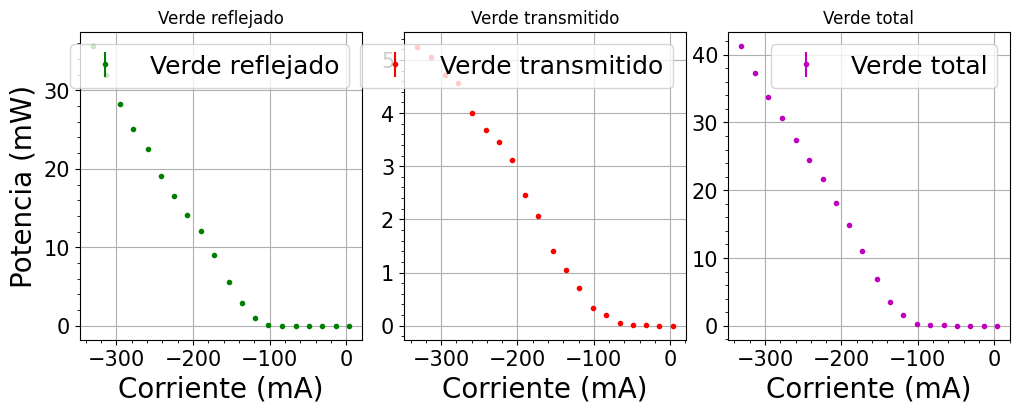

In [129]:
# Definimos listas para las labels y los colores de los graficos
labels = mediciones
marker_color = ["g","r", "m"]

fig, axs = plt.subplots(1,len(labels), figsize=(12,4))
for i, ax in enumerate(fig.axes):
    color = mediciones[i]

    corr_values = dic_pow[f"corr:{color}"]
    POW_values = dic_pow[f"pow:{color}"] 
    POW_var_values = dic_pow[f"sigma:{color}"] 

    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,fmt = ".", color = f"{marker_color[i]}", label = f"{labels[i]}")
    ax.set_xlabel("Corriente (mA)")
    if i == 0:
        ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}")
    ax.legend(loc = "upper right")

plt.subplots_adjust(wspace=0.15, hspace=0)
#plt.savefig("../imagenes/Medidor de potencia/Potencia en función de la corriente.png")
plt.show()

## Todas las mediciones

In [130]:
mediciones = ["Verde reflejado", "Verde transmitido", "Infrarrojo transmitido", "Verde total", "Infrarrojo total"]
# Para guardar los datos
dic_pow = {}

for color in mediciones:
    file_name = f"../mediciones/D.D/Medidor de potencia/Barrido para potencia {color} 2205.pickle"

    *_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)

    # Metemos los datos en un diccionario
    dic_pow[f"corr:{color}"] = np.array(corr_values)
    dic_pow[f"pow:{color}"] = np.array(POW_values)
    dic_pow[f"sigma:{color}"] = np.array(POW_var_values)

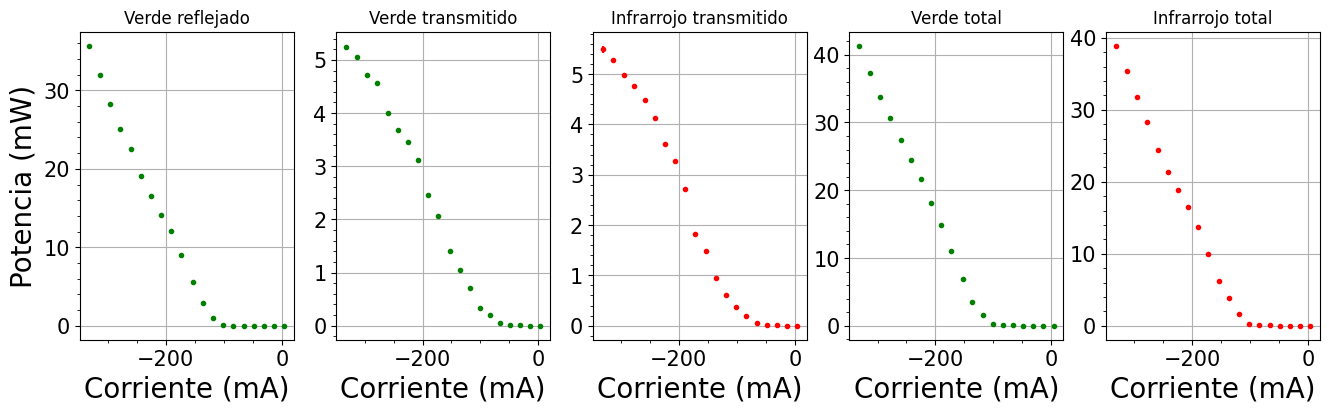

In [131]:
# Definimos listas para las labels y los colores de los graficos
labels = mediciones
marker_color = ["g","g", "r", "g", "r"]

fig, axs = plt.subplots(1,len(labels), figsize=(16,4))
for i, ax in enumerate(fig.axes):
    color = mediciones[i]

    corr_values = dic_pow[f"corr:{color}"]
    POW_values = dic_pow[f"pow:{color}"] 
    POW_var_values = dic_pow[f"sigma:{color}"] 

    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,fmt = f".{marker_color[i]}", label = f"{labels[i]}")
    ax.set_xlabel("Corriente (mA)")
    if i == 0:
        ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}")
    # ax.legend(loc = "upper right")
plt.show()

# Análisis de relaciones entre las potencias

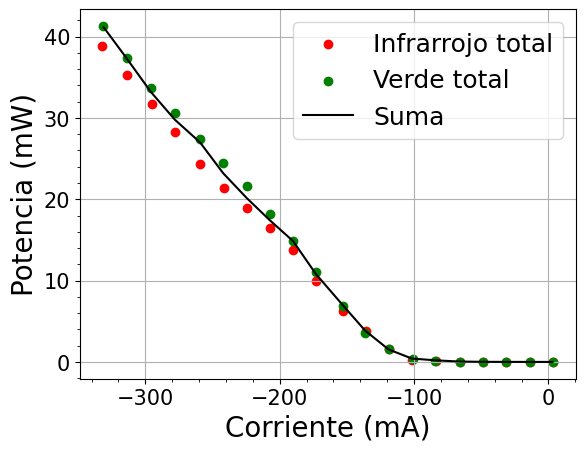

In [132]:
plt.scatter(dic_pow["corr:Infrarrojo total"],dic_pow["pow:Infrarrojo total"], label = "Infrarrojo total", color = "r")
plt.scatter(dic_pow["corr:Verde total"],dic_pow["pow:Verde total"], label = "Verde total", color = "g")

plt.plot(dic_pow["corr:Verde reflejado"], dic_pow["pow:Verde reflejado"]+dic_pow["pow:Infrarrojo transmitido"], label = "Suma", color = "k")

plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.legend()
plt.show()

In [133]:
def lineal(x, a, b): return a*np.array(x)+b

def ajuste_lineal(x: np.ndarray, y: np.array, y_err: np.ndarray) -> List[float]:

    popt, pcov = curve_fit(lineal, x,y, sigma = y_err)

    a, b = popt

    return a, b, pcov

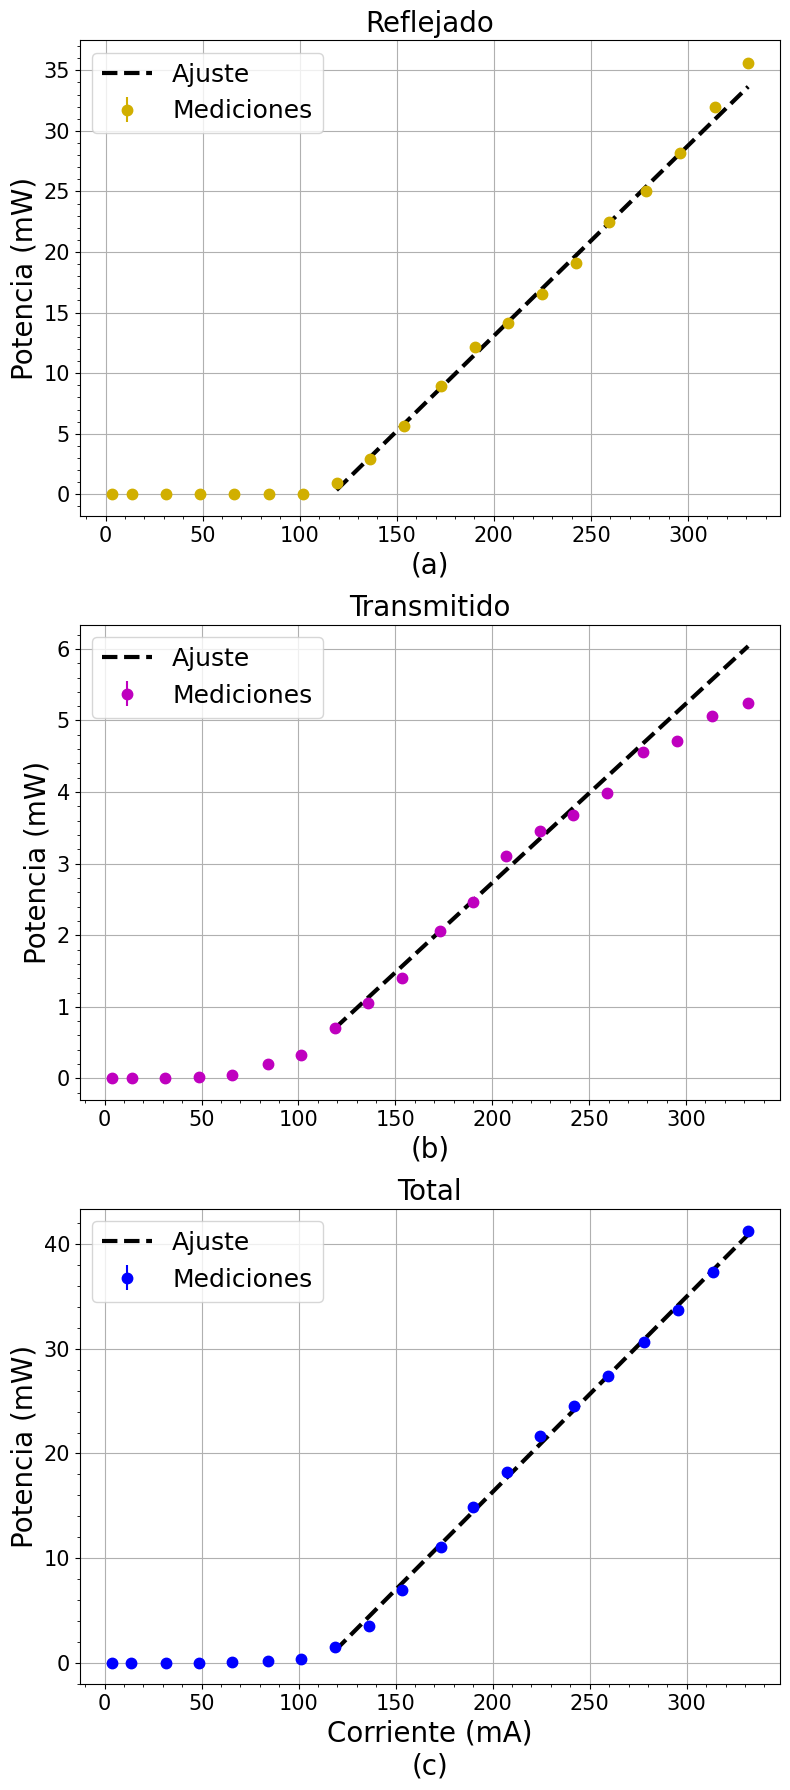

In [136]:
files = ["Verde reflejado", "Verde transmitido", "Verde total"] # Cambié por verde transmitido
# labels = ["Verde reflejado", "Verde transmitido", "Total"]
labels = ["Reflejado", "Transmitido", "Total"]
# marker_color = ["#47DF01","#ff0000", "m"] # "#7CE577" # Colores verde y rojo 
marker_color = ["#D1AF00","m", "b"] 
letras = ["(a)", "(b)", "(c)"]
lista_POW_ajuste = []

# fig, axs = plt.subplots(nrows = 1, ncols = len(files), figsize=(16,6))
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize=(8,18))
for i, ax in enumerate(fig.axes):
    
    color = files[i]

    corr_values = np.abs(dic_pow[f"corr:{color}"])#[:13] 
    POW_values = dic_pow[f"pow:{color}"]#[:13] 
    POW_var_values = dic_pow[f"sigma:{color}"]#[:13] 

    a, b, cov_matrix = ajuste_lineal(corr_values[:13],POW_values[:13], POW_var_values[:13])# Ajustamos el rango en el que se prende el láser
    
    corr_ajuste = np.linspace(min(corr_values[:13]), max(corr_values[:13]), 1000)
    POW_ajuste = lineal(corr_ajuste,a,b)
    lista_POW_ajuste.append(POW_ajuste)

    # sigma = np.sqrt(cov_matrix[1,1]+(corr_ajuste**2)*cov_matrix[0,0]+2*corr_ajuste*cov_matrix[0,1])
    # y_1 = POW_ajuste+sigma
    # y_2 = POW_ajuste-sigma

    # ax.fill(
    #     np.append(corr_ajuste, corr_ajuste[::-1]),
    #     np.append(y_1, y_2[::-1]),
    #     color = marker_color[i],
    #     alpha = 0.5,
    #     label = "Bandas de error del ajuste"
    # )
 

    # ax.set_yscale("log")
    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,marker = ".", ms=15, ls = "", color = f"{marker_color[i]}", label = "Mediciones")
    ax.plot(corr_ajuste, POW_ajuste,color = "k", ls = "--", lw=3, label = "Ajuste")
    ax.set_xlabel(letras[i])
    # ax.set_xlabel(f"Corriente (mA)\n{letras[i]}")
    # if i == 0:
    ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}", fontsize = 20)
    ax.legend(loc = "best")

ax.set_xlabel(f"Corriente (mA)\n{letras[i]}")
plt.subplots_adjust(wspace=0.21, hspace=0.5)
# plt.savefig("../imagenes/Medidor de potencia/potencia + ajuste.svg")
fig.tight_layout()
plt.show()

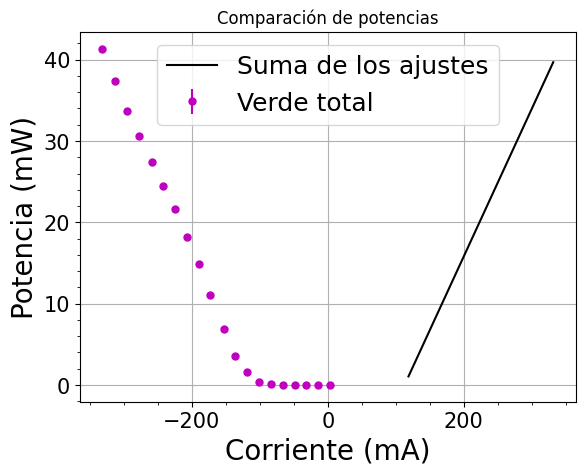

In [99]:
pow_suma = lista_POW_ajuste[0]+lista_POW_ajuste[1]

plt.plot(corr_ajuste, pow_suma, label = "Suma de los ajustes", color = "k")
#plt.scatter(dic_pow["corr:Infrarrojo total"],dic_pow["pow:Infrarrojo total"], label = "Infrarrojo total", color = "r")
plt.errorbar(dic_pow["corr:Verde total"], dic_pow["pow:Verde total"],yerr = dic_pow[f"sigma:Verde total"],marker = ".", ms = 10, ls = "", color = "m", label = "Verde total")
plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.title("Comparación de potencias")
plt.legend()
#plt.savefig("../imagenes/Medidor de potencia/Comparación de potencias.png")
plt.show()

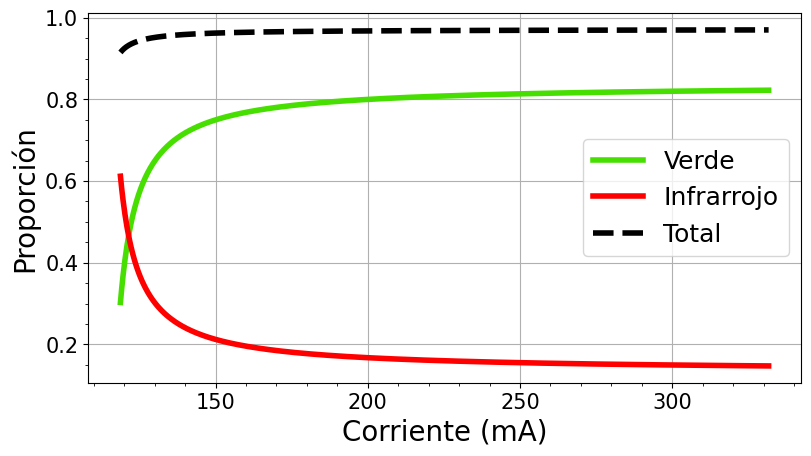

In [100]:
pow_verde, pow_rojo, pow_total = lista_POW_ajuste

plt.figure(figsize=(9.2,4.8))
plt.plot(corr_ajuste,pow_verde/pow_total, label = "Verde", color = "#47DF01", lw=4)
plt.plot(corr_ajuste,pow_rojo/pow_total, label = "Infrarrojo", color = "#ff0000", lw=4)
plt.plot(corr_ajuste, pow_suma/pow_total, label = "Total", color = "k", ls = "--", lw=4)
plt.xlabel("Corriente (mA)")
plt.ylabel("Proporción")
plt.legend()
plt.savefig("../imagenes/Medidor de potencia/Proporcion de potencia del laser.svg")
plt.show()

Para calcular cuanto más grande es la potencia del verde respecto al rojo

In [101]:
corr_ajuste[148]

150.2828641975309

In [102]:
np.mean(pow_verde[148-8:148+9]/pow_rojo[148-8:148+9])

3.5415136427699268

In [103]:
np.std(pow_verde[148-8:148+9]/pow_rojo[148-8:148+9], ddof = 1)

0.048847280200421325

In [104]:
np.mean(pow_verde/pow_rojo)

4.614712831440556

In [105]:
np.std(pow_verde/pow_rojo, ddof = 1)

1.0953145811647147

# Análisis correcto de proporciones

In [106]:
dic_R = pickle.load(open(f"../mediciones/D.D/Medidor de potencia/Barrido para potencia Verde reflejado 2205.pickle", "rb"))
dic_T = pickle.load(open(f"../mediciones/D.D/Medidor de potencia/Barrido para potencia Verde transmitido 2205.pickle", "rb"))

In [107]:
raw_pow_R = [dic_R[offset]["POW"]*1000 for offset in dic_R.keys()]
raw_pow_T = [dic_T[offset]["POW"]*1000 for offset in dic_T.keys()]

cov = np.array([np.cov(raw_pow_R[i],raw_pow_T[i])[0,1] for i in range(len(raw_pow_T))][:13])

cov

array([ 6.76536397e-05,  7.74324470e-04,  6.18772370e-04, -1.46310646e-04,
       -3.36795591e-04,  3.56823250e-05, -5.74783213e-06, -6.70545013e-06,
        3.66978849e-06,  4.02214103e-07, -1.35208921e-05, -5.52665297e-06,
       -4.34635485e-06])

In [108]:
pow_T, pow_R = dic_pow[f"pow:Verde transmitido"][:13], dic_pow[f"pow:Verde reflejado"][:13] #pow_verde, pow_rojo
corr = corr_values[:13]
resp_V = 1#3.015
resp_R = 1#3.03

# No polarizada
t_V = 1.262862413/100
t_R = 67.65880182/100
r_V = 98.78617556/100
r_R = 31.94356449/100

# P polarizada  
t_V = 2.436381032/100
t_R = 82.0684772/100
r_V = 97.64165045/100
r_R = 18.160778/100

# S polarizada
t_V = 0.08934379369/100
t_R = 53.24912643/100
r_V = 99.93070068/100
r_R = 45.72635098/100

a = t_V/resp_V
b = t_R/resp_R
c = r_V/resp_V
d = r_R/resp_R

In [109]:
corr = (dic_pow[f"corr:Verde transmitido"][:13]+dic_pow[f"corr:Verde reflejado"][:13])/2
corr_err = np.sqrt(((dic_pow[f"corr:Verde transmitido"][:13]-corr)**2+(dic_pow[f"corr:Verde reflejado"][:13]-corr)**2))

pow_T_err = dic_pow[f"sigma:Verde transmitido"][:13]
pow_R_err = dic_pow[f"sigma:Verde reflejado"][:13]

In [110]:
R_real = (pow_R-pow_T*c/a)/(d-b*c/a)
V_real = (pow_R-pow_T*d/b)/(c-d*a/b) #(pow_T-R_real*b)/a

I = V_real+R_real
# I /= np.max(I)

R_real_err = np.sqrt((pow_R_err/(d-b*c/a))**2+((pow_T_err*c/a)/(d-b*c/a))**2-2*cov*((c/a)/((d-b*c/a)**2)))
V_real_err = np.sqrt((pow_R_err/(c-d*a/b))**2+((pow_T_err*d/b)/(c-d*a/b))**2-2*cov*((d/b))/((c-d*a/b)**2))

I_err = np.sqrt((V_real_err)**2+(R_real_err)**2)

In [111]:
V_err_norm = np.sqrt((V_real_err/I)**2+(V_real*I_err/(I**2))**2)
R_err_norm = np.sqrt((R_real_err/I)**2+(R_real*I_err/(I**2))**2)

In [112]:
V_real, R_real

(array([35.51705468, 31.80732258, 27.98232377, 24.74881075, 22.24315137,
        18.82662979, 16.25183689, 13.86516014, 11.93591312,  8.77514258,
         5.45717576,  2.73852871,  0.79692212]),
 array([5.33790477, 5.2166846 , 4.91103027, 4.82169997, 4.20465109,
        3.91834881, 3.72252584, 3.37866823, 2.64885175, 2.25192747,
        1.54435247, 1.20491023, 0.83286257]))

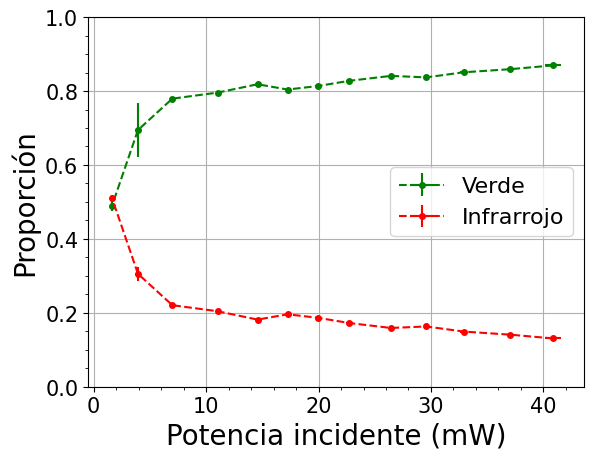

In [113]:
plt.errorbar(np.abs(I),V_real/I,xerr = corr_err, yerr = V_err_norm,fmt =".--", color = "g", label = "Verde", ms = 8)
plt.errorbar(np.abs(I),R_real/I,xerr = corr_err, yerr= R_err_norm,fmt =".--", color = "r", label = "Infrarrojo", ms = 8)
# plt.plot(corr,(V_real+R_real)/I, color = "k", label = "Suma")
plt.xlabel("Potencia incidente (mW)")
plt.ylabel("Proporción")
plt.legend(fontsize = 16)
plt.ylim([0,1])
plt.show()

In [115]:
params = [[2.436381032/100, 82.0684772/100, 97.64165045/100,18.160778/100], [0.08934379369/100, 53.24912643/100, 99.93070068/100, 45.72635098/100]]

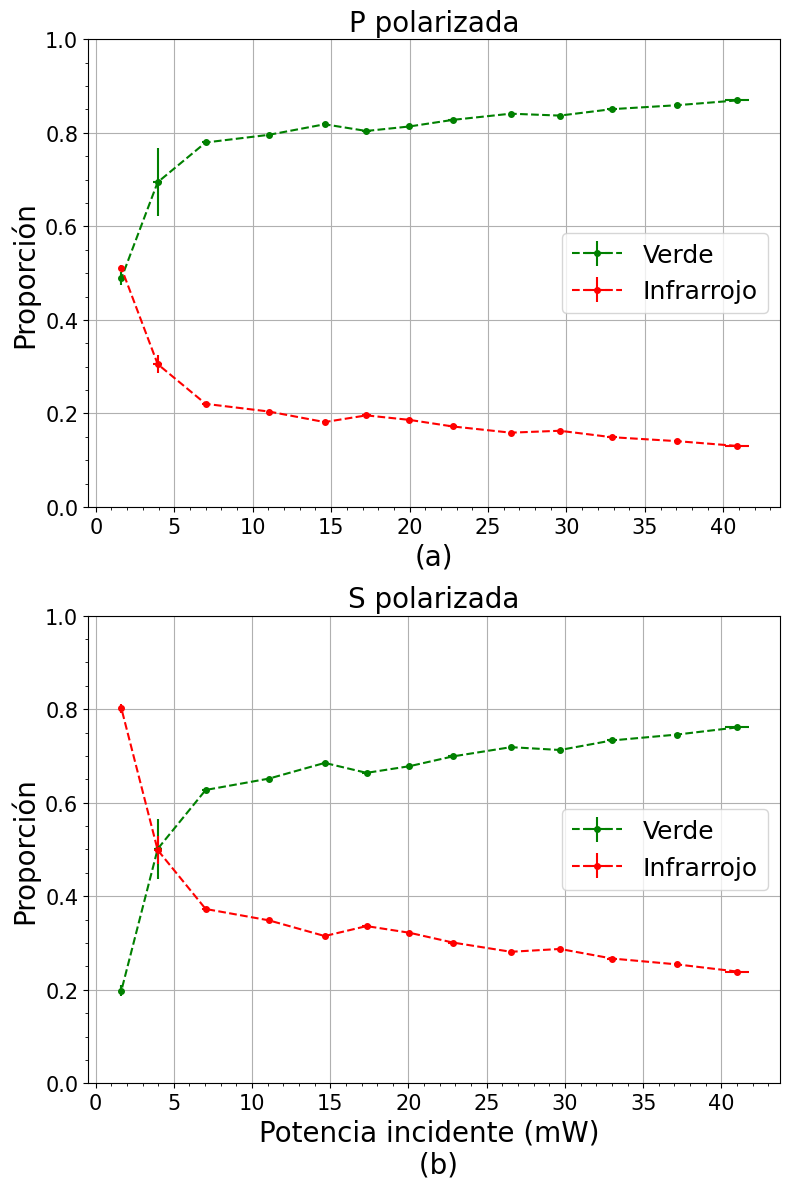

In [125]:
titles = ["P polarizada", "S polarizada"]

fig, axs = plt.subplots(nrows = 2, figsize=(8,12))

for i, ax in enumerate(fig.axes):
    
    a = params[i][0]/resp_V
    b = params[i][1]/resp_R
    c = params[i][2]/resp_V
    d = params[i][3]/resp_R

    R_real = (pow_R-pow_T*c/a)/(d-b*c/a)
    V_real = (pow_R-pow_T*d/b)/(c-d*a/b) #(pow_T-R_real*b)/a

    I = V_real+R_real
    # I /= np.max(I)

    R_real_err = np.sqrt((pow_R_err/(d-b*c/a))**2+((pow_T_err*c/a)/(d-b*c/a))**2-2*cov*((c/a)/((d-b*c/a)**2)))
    V_real_err = np.sqrt((pow_R_err/(c-d*a/b))**2+((pow_T_err*d/b)/(c-d*a/b))**2-2*cov*((d/b))/((c-d*a/b)**2))

    I_err = np.sqrt((V_real_err)**2+(R_real_err)**2)

    V_err_norm = np.sqrt((V_real_err/I)**2+(V_real*I_err/(I**2))**2)
    R_err_norm = np.sqrt((R_real_err/I)**2+(R_real*I_err/(I**2))**2)


    ax.set_title(titles[i], fontsize = 20)
    ax.errorbar(np.abs(I),V_real/I,xerr = corr_err, yerr = V_err_norm,fmt =".--", color = "g", label = "Verde", ms = 8)
    ax.errorbar(np.abs(I),R_real/I,xerr = corr_err, yerr= R_err_norm,fmt =".--", color = "r", label = "Infrarrojo", ms = 8)
    # ax.plot(corr,(V_real+R_real)/I, color = "k", label = "Suma")
    ax.set_xlabel(letras[i])
    ax.set_ylabel("Proporción")
    ax.legend(fontsize = 18, loc = "center right")
    ax.set_ylim([0,1])


ax.set_xlabel(f"Potencia incidente (mW) \n {letras[i]}")

fig.tight_layout()
plt.show()

# Figura individual

In [319]:
file_name = f"../mediciones/D.D/Medidor de potencia/Barrido para potencia total - San Damian.pickle"

*_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)


In [320]:
a, b, cov_matrix = ajuste_lineal(corr_values[:13],POW_values[:13], POW_var_values[:13])# Ajustamos el rango en el que se prende el láser
    
corr_ajuste = np.linspace(min(corr_values[:13]), max(corr_values[:13]), 1000)
POW_ajuste = lineal(corr_ajuste,a,b)

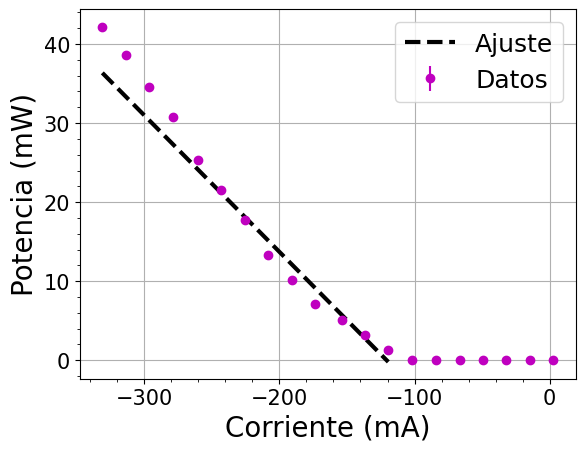

In [321]:
plt.plot(corr_ajuste, POW_ajuste, label = "Ajuste", color = "k", ls = "--", lw = 3)
#plt.scatter(dic_pow["corr:Infrarrojo total"],dic_pow["pow:Infrarrojo total"], label = "Infrarrojo total", color = "r")
plt.errorbar(corr_values,POW_values,yerr = POW_var_values,marker = ".", ms = 12, ls = "", color = "m", label = "Datos")
plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
# plt.title("Comparación de potencias")
plt.legend()
#plt.savefig("../imagenes/Medidor de potencia/Comparación de potencias.png")
plt.show()

# Barrido con San Damian

In [322]:
file_name = f"../mediciones/D.D/Medidor de potencia/Barrido para potencia total - San Damian.pickle"

*_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)


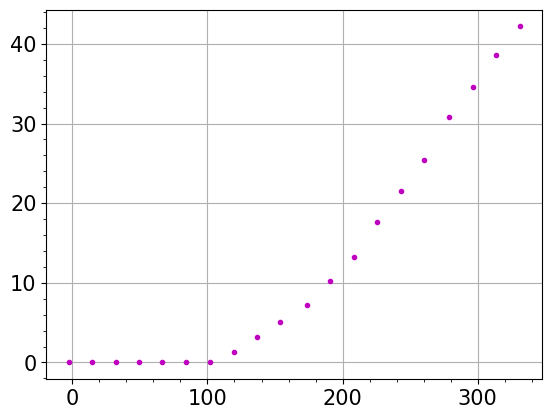

In [323]:
plt.plot(-np.array(corr_values), POW_values,".", c = "m")